In [1]:
# binder https://hub.gke.mybinder.org/user/blychs-climatologia_fisica-dckeuhha/notebooks/practica2.ipynb
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
import pandas as pd
import xarray as xr
import copy
from metpy.units import units
import metpy.calc as mpcalc
import metpy.constants as mpconsts
import datetime as dt
import calendar
import seaborn as sns
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import matplotlib as mpl
#from funciones_meteo import load_file, ploteo_general, calculate_h

In [2]:
import funciones_meteo as fm
# set the colormap and centre the colorbar
class MidpointNormalize(colors.Normalize):
	"""
	Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

	e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
	"""
	def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
		self.midpoint = midpoint
		colors.Normalize.__init__(self, vmin, vmax, clip)

	def __call__(self, value, clip=None):
		# I'm ignoring masked values and all kinds of edge cases to make a
		# simple example...
		x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
		return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))
    

def calculate_k(u, v):
    return 0.5 * ((u * u) + (v * v)) 
    
    
def calculateF_A(h, k, u, v):
    """Calcula valor de F_A en superficie como
    (1/g (h + k) u, 1/g(h + k) v)"""
    g = mpconsts.g
    return 1/g * (h + k) * u, 1/g * (h + k) * v

In [3]:
# Generacion mascara continente oceano
pr_obs = xr.open_dataset('observacionales/precip.mon.total.v7_197601-200512_2.5_anu.nc')
mask_land = 1 * np.ones((pr_obs.dims['lat'], pr_obs.dims['lon'])) * np.isfinite(pr_obs.precip.isel(time=0))
mask_ocean = 1 * np.ones((pr_obs.dims['lat'], pr_obs.dims['lon'])) * np.isnan(pr_obs.precip.isel(time=0))
t_land = xr.open_dataset('observacionales/tmp_cru_ts3.20_197601-200512_2.5_anu.nc')
t_ocean = xr.open_dataset('observacionales/sst.mnmean.v4_197601-200512_2.5_anu.nc')
t_global = t_land.tmp.combine_first(t_ocean.sst)
del pr_obs

# Datos de reanalisis
pres_r = xr.open_dataset('reanalysis/pl.mon.mean.nc').metpy.parse_cf()
tmp_r  = xr.open_dataset('reanalysis/tmp.mon.mean.nc').metpy.parse_cf()
hum_r  = xr.open_dataset('reanalysis/rhum.mon.mean.nc').metpy.parse_cf()
e_sat  = 10**(((0.7859+0.03477*tmp_r.air)/(1 + 0.00412 * tmp_r.air)) + 2)
e_a    = (hum_r.rhum / 100) * e_sat
q_r = 0.622/((pres_r.pres * 100/e_a) - 0.378)

# Datos del modelo CMIP5
t_c5_hist     = fm.load_file('NorESM1-M/tas_Amon_NorESM1-M_historical_r*i1p1_197601-200512_2.5_anu.nc')
t_c5_26_close = fm.load_file('NorESM1-M/tas_Amon_NorESM1-M_rcp26_r1i1p1_202001-204912_2.5_anu.nc')
t_c5_26_far   = fm.load_file('NorESM1-M/tas_Amon_NorESM1-M_rcp26_r1i1p1_207001-209912_2.5_anu.nc')
t_c5_85_close = fm.load_file('NorESM1-M/tas_Amon_NorESM1-M_rcp85_r1i1p1_202001-204912_2.5_anu.nc')
t_c5_85_far   = fm.load_file('NorESM1-M/tas_Amon_NorESM1-M_rcp85_r1i1p1_207001-209912_2.5_anu.nc')

h_c5_hist     = fm.load_file('NorESM1-M/huss_historical_r*_anu.nc')
h_c5_26_close = fm.load_file('NorESM1-M/huss_Amon_NorESM1-M_rcp26_r1_202001-204912_2.5_anu.nc')
h_c5_26_far   = fm.load_file('NorESM1-M/huss_Amon_NorESM1-M_rcp26_r1_207001-209912_2.5_anu.nc')
h_c5_85_close = fm.load_file('NorESM1-M/huss_Amon_NorESM1-M_rcp85_r1_202001-204912_2.5_anu.nc')
h_c5_85_far   = fm.load_file('NorESM1-M/huss_Amon_NorESM1-M_rcp85_r1_207001-209912_2.5_anu.nc')

etp_c5_hist     = fm.load_file('NorESM1-M/etp_Amon_NorESM1-M_historical_r*i1p1_197601-200512_2.5_anu.nc')
etp_c5_26_close = fm.load_file('NorESM1-M/etp_Amon_NorESM1-M_rcp26_r1i1p1_202001-204912_2.5_anu.nc')
etp_c5_26_far   = fm.load_file('NorESM1-M/etp_Amon_NorESM1-M_rcp26_r1i1p1_207001-209912_2.5_anu.nc')
etp_c5_85_close = fm.load_file('NorESM1-M/etp_Amon_NorESM1-M_rcp85_r1i1p1_202001-204912_2.5_anu.nc')
etp_c5_85_far   = fm.load_file('NorESM1-M/etp_Amon_NorESM1-M_rcp85_r1i1p1_207001-209912_2.5_anu.nc')

#Datos del modelo CMIP6
t_c6_hist      = fm.load_file('NorESM2-LM/tas_Amon_NorESM2-LM_historical_r*_2.5.nc')
t_c6_126_close = fm.load_file('NorESM2-LM/tas_Amon_NorESM2-LM_ssp126_r1_2020-2049_2.5.nc')
t_c6_126_far   = fm.load_file('NorESM2-LM/tas_Amon_NorESM2-LM_ssp126_r1_2070-2099_2.5.nc')
t_c6_585_close = fm.load_file('NorESM2-LM/tas_Amon_NorESM2-LM_ssp585_r1_2020-2049_2.5.nc')
t_c6_585_far   = fm.load_file('NorESM2-LM/tas_Amon_NorESM2-LM_ssp585_r1_2070-2099_2.5.nc')

h_c6_hist      = fm.load_file('NorESM2-LM/huss_Amon_NorESM2-LM_historical_r*_2.5.nc')
h_c6_126_close = fm.load_file('NorESM2-LM/huss_Amon_NorESM2-LM_ssp126_r1_2020-2049_2.5.nc')
h_c6_126_far   = fm.load_file('NorESM2-LM/huss_Amon_NorESM2-LM_ssp126_r1_2070-2099_2.5.nc')
h_c6_585_close = fm.load_file('NorESM2-LM/huss_Amon_NorESM2-LM_ssp585_r1_2020-2049_2.5.nc')
h_c6_585_far   = fm.load_file('NorESM2-LM/huss_Amon_NorESM2-LM_ssp585_r1_2070-2099_2.5.nc')

etp_c6_hist      = fm.load_file('NorESM2-LM/etp_Amon_NorESM2-LM_historical_r*_2.5_anu.nc')
etp_c6_126_close = fm.load_file('NorESM2-LM/etp_Amon_NorESM2-LM_ssp126_r1_2020-2049_2.5_anu.nc')
etp_c6_126_far   = fm.load_file('NorESM2-LM/etp_Amon_NorESM2-LM_ssp126_r1_2070-2099_2.5_anu.nc')
etp_c6_585_close = fm.load_file('NorESM2-LM/etp_Amon_NorESM2-LM_ssp585_r1_2020-2049_2.5_anu.nc')
etp_c6_585_far   = fm.load_file('NorESM2-LM/etp_Amon_NorESM2-LM_ssp585_r1_2070-2099_2.5_anu.nc')

u_c6_hist      = fm.load_file('NorESM2-LM/ua850_Amon_NorESM2-LM_historical_r*_2.5.nc')
u_c6_126_close = fm.load_file('NorESM2-LM/ua850_Amon_NorESM2-LM_ssp126_r1_2020-2049_2.5.nc')
u_c6_126_far   = fm.load_file('NorESM2-LM/ua850_Amon_NorESM2-LM_ssp126_r1_2070-2099_2.5.nc')
u_c6_585_close = fm.load_file('NorESM2-LM/ua850_Amon_NorESM2-LM_ssp585_r1_2020-2049_2.5.nc')
u_c6_585_far   = fm.load_file('NorESM2-LM/ua850_Amon_NorESM2-LM_ssp585_r1_2070-2099_2.5.nc')

v_c6_hist      = fm.load_file('NorESM2-LM/va850_Amon_NorESM2-LM_historical_r*_2.5.nc')
v_c6_126_close = fm.load_file('NorESM2-LM/va850_Amon_NorESM2-LM_ssp126_r1_2020-2049_2.5.nc')
v_c6_126_far   = fm.load_file('NorESM2-LM/va850_Amon_NorESM2-LM_ssp126_r1_2070-2099_2.5.nc')
v_c6_585_close = fm.load_file('NorESM2-LM/va850_Amon_NorESM2-LM_ssp585_r1_2020-2049_2.5.nc')
v_c6_585_far   = fm.load_file('NorESM2-LM/va850_Amon_NorESM2-LM_ssp585_r1_2070-2099_2.5.nc')

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longi

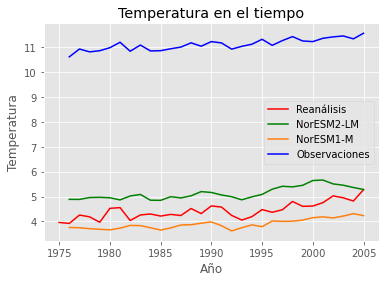

/home/tobi/programs/anaconda3/envs/metpy/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


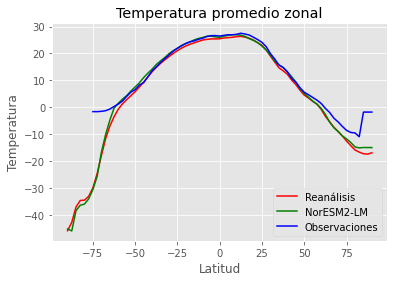

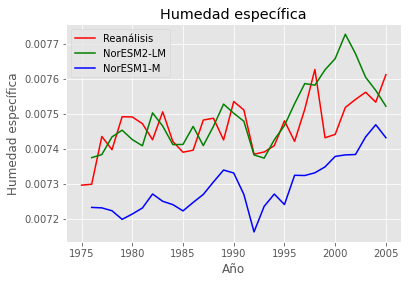

4.04931640625
5.288330078125


In [4]:
#fm.ploteo_general(etp_c5_hist['ds'].etp.mean(dim='time'), projection=ccrs.Robinson())
#plt.show()
tmp_r.air.metpy.convert_units('degC')
with plt.style.context('ggplot'):
    (tmp_r.air.mean(dim=('lat', 'lon')).groupby('time.year').mean(dim='time')).plot(color='r', label='Reanálisis')
    (t_c6_hist['ds'].tas.mean(dim=('lat', 'lon')).groupby('time.year').mean(
    dim='time') - 273.15).plot(color='g', label='NorESM2-LM')
    (t_c5_hist['ds'].tas.mean(dim=('lat', 'lon')).groupby('time.year').mean(
    dim='time') - 273.15).plot(color='tab:orange', label='NorESM1-M')
    t_global.mean(dim=('lat', 'lon')).groupby('time.year').mean(dim='time').plot(color='b', label='Observaciones')
    plt.legend()
    plt.title('Temperatura en el tiempo')
    plt.ylabel('Temperatura')
    plt.xlabel('Año')
plt.show()


with plt.style.context('ggplot'):
    (tmp_r.air.mean(dim=('lon')).mean(dim='time')).plot(color='r', label='Reanálisis')
    (t_c6_hist['ds'].tas.mean(dim=('lon')).mean(dim='time') - 273.15).plot(color='g', label='NorESM2-LM')
    t_global.mean(dim=('lon')).mean(dim='time').plot(color='b', label='Observaciones')
    plt.legend()
    plt.title('Temperatura promedio zonal')
    plt.ylabel('Temperatura')
    plt.xlabel('Latitud')
plt.show()

with plt.style.context('ggplot'):
    (q_r.mean(dim=('lat', 'lon')).groupby('time.year').mean(dim='time')).plot(color='r', label='Reanálisis')
    (h_c6_hist['ds'].huss.mean(dim=('lat', 'lon')).groupby('time.year').mean(
    dim='time')).plot(color='g', label='NorESM2-LM')
    h_c5_hist['ds'].huss.mean(dim=('lat', 'lon')).groupby('time.year').mean(dim='time').plot(color='b',
                                                                                             label='NorESM1-M')
    plt.legend()
    plt.title('Humedad específica')
    plt.ylabel('Humedad específica')
    plt.xlabel('Año')
plt.show()

print(t_c5_hist['ds'].tas.mean().values - 273)
print(t_c6_hist['ds'].tas.mean().values - 273)

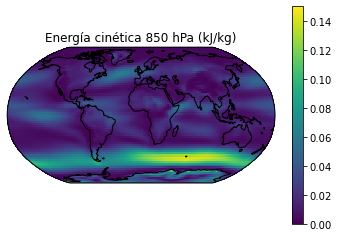

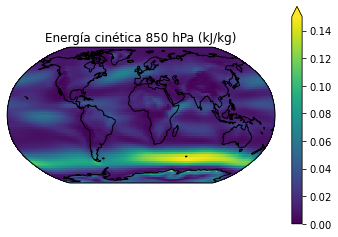

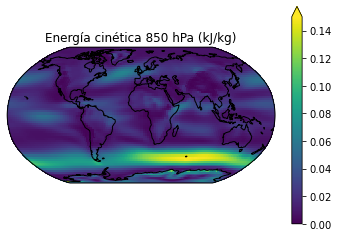

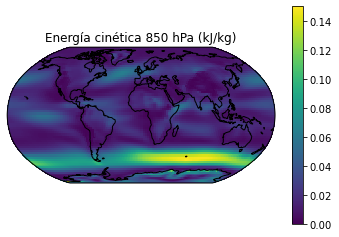

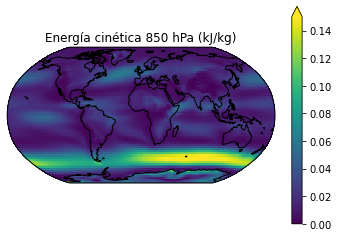

In [5]:
k_hist = calculate_k(u_c6_hist['ds'].ua, v_c6_hist['ds'].va)
ax = plt.axes(projection=ccrs.Robinson())
(k_hist.mean(dim='time',keep_attrs=True) / 1000 ).plot(vmin=0, vmax=0.15, transform=ccrs.PlateCarree())
ax.coastlines()
plt.title('Energía cinética 850 hPa (kJ/kg)')
plt.show()

k_c6_126_close = calculate_k(u_c6_126_close['ds'].ua, v_c6_126_close['ds'].va)
ax = plt.axes(projection=ccrs.Robinson())
(k_c6_126_close.mean(dim='time',keep_attrs=True) / 1000 ).plot(vmin=0, vmax=0.15, transform=ccrs.PlateCarree())
ax.coastlines()
plt.title('Energía cinética 850 hPa (kJ/kg)')
plt.show()

k_c6_126_far = calculate_k(u_c6_126_far['ds'].ua, v_c6_126_far['ds'].va)
ax = plt.axes(projection=ccrs.Robinson())
(k_c6_126_far.mean(dim='time',keep_attrs=True) / 1000 ).plot(vmin=0, vmax=0.15, transform=ccrs.PlateCarree())
ax.coastlines()
plt.title('Energía cinética 850 hPa (kJ/kg)')
plt.show()

k_c6_585_close = calculate_k(u_c6_585_close['ds'].ua, v_c6_585_close['ds'].va)
ax = plt.axes(projection=ccrs.Robinson())
(k_c6_585_close.mean(dim='time',keep_attrs=True) / 1000 ).plot(vmin=0, vmax=0.15, transform=ccrs.PlateCarree())
ax.coastlines()
plt.title('Energía cinética 850 hPa (kJ/kg)')
plt.show()

k_c6_585_far = calculate_k(u_c6_585_far['ds'].ua, v_c6_585_far['ds'].va)
ax = plt.axes(projection=ccrs.Robinson())
(k_c6_585_far.mean(dim='time',keep_attrs=True) / 1000 ).plot(vmin=0, vmax=0.15, transform=ccrs.PlateCarree())
ax.coastlines()
plt.title('Energía cinética 850 hPa (kJ/kg)')
plt.show()

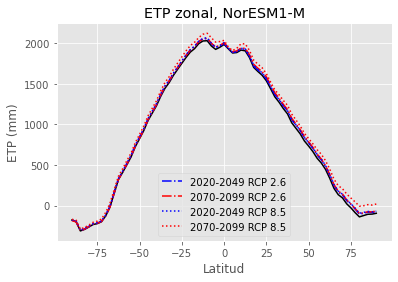

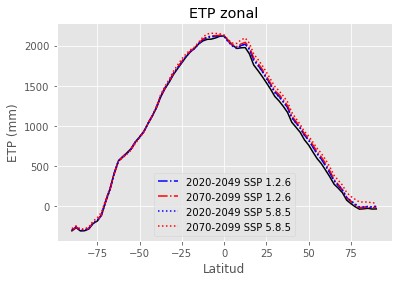

In [6]:
with plt.style.context('ggplot'):
    etp_c5_hist['ds'].etp.mean(dim=('lon', 'time')).plot(color='k')
    etp_c5_26_close['ds'].etp.mean(dim=('lon', 'time')).plot(color='b', linestyle='dashdot',
                                                             label='2020-2049 RCP 2.6')
    etp_c5_26_far['ds'].etp.mean(dim=('lon', 'time')).plot(color='r', linestyle='dashdot',
                                                           label='2070-2099 RCP 2.6')
    etp_c5_85_close['ds'].etp.mean(dim=('lon', 'time')).plot(color='b', linestyle=':',
                                                             label='2020-2049 RCP 8.5')
    etp_c5_85_far['ds'].etp.mean(dim=('lon', 'time')).plot(color='r', linestyle=':',
                                                           label='2070-2099 RCP 8.5')
    plt.legend()
    plt.title('ETP zonal, NorESM1-M')
    plt.xlabel('Latitud')
    plt.ylabel('ETP (mm)')
plt.show()

with plt.style.context('ggplot'):
    etp_c6_hist['ds'].etp.mean(dim=('lon', 'time')).plot(color='k')
    etp_c6_126_close['ds'].etp.mean(dim=('lon', 'time')).plot(color='b', linestyle='dashdot',
                                                              label='2020-2049 SSP 1.2.6')
    etp_c6_126_far['ds'].etp.mean(dim=('lon', 'time')).plot(color='r', linestyle='dashdot',
                                                            label='2070-2099 SSP 1.2.6')
    etp_c6_585_close['ds'].etp.mean(dim=('lon', 'time')).plot(color='b', linestyle=':',
                                                              label='2020-2049 SSP 5.8.5')
    etp_c6_585_far['ds'].etp.mean(dim=('lon', 'time')).plot(color='r', linestyle=':',
                                                            label='2070-2099 SSP 5.8.5')
    plt.title('ETP zonal')
    plt.xlabel('Latitud')
    plt.ylabel('ETP (mm)')
    plt.legend(loc=0)
plt.show()



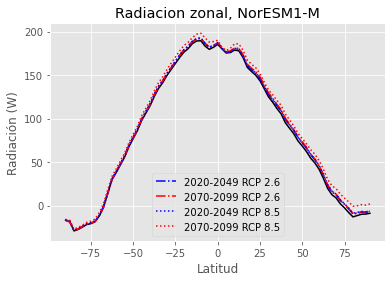

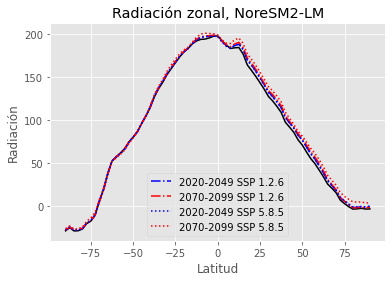

In [7]:
def radiacion(etp):
    return etp * 245000 / 2628802.88 

with plt.style.context('ggplot'):
    radiacion(etp_c5_hist['ds'].etp).mean(dim=('lon', 'time')).plot(color='k')
    radiacion(etp_c5_26_close['ds'].etp).mean(dim=('lon', 'time')).plot(color='b', linestyle='dashdot',
                                                             label='2020-2049 RCP 2.6')
    radiacion(etp_c5_26_far['ds'].etp).mean(dim=('lon', 'time')).plot(color='r', linestyle='dashdot',
                                                           label='2070-2099 RCP 2.6')
    radiacion(etp_c5_85_close['ds'].etp).mean(dim=('lon', 'time')).plot(color='b', linestyle=':',
                                                             label='2020-2049 RCP 8.5')
    radiacion(etp_c5_85_far['ds'].etp).mean(dim=('lon', 'time')).plot(color='r', linestyle=':',
                                                           label='2070-2099 RCP 8.5')
    plt.legend()
    plt.title('Radiacion zonal, NorESM1-M')
    plt.xlabel('Latitud')
    plt.ylabel('Radiación (W)')
plt.show()

with plt.style.context('ggplot'):
    radiacion(etp_c6_hist['ds'].etp).mean(dim=('lon', 'time')).plot(color='k')
    radiacion(etp_c6_126_close['ds'].etp).mean(dim=('lon', 'time')).plot(color='b', linestyle='dashdot',
                                                              label='2020-2049 SSP 1.2.6')
    radiacion(etp_c6_126_far['ds'].etp).mean(dim=('lon', 'time')).plot(color='r', linestyle='dashdot',
                                                            label='2070-2099 SSP 1.2.6')
    radiacion(etp_c6_585_close['ds'].etp).mean(dim=('lon', 'time')).plot(color='b', linestyle=':',
                                                              label='2020-2049 SSP 5.8.5')
    radiacion(etp_c6_585_far['ds'].etp).mean(dim=('lon', 'time')).plot(color='r', linestyle=':',
                                                            label='2070-2099 SSP 5.8.5')
    plt.title('Radiación zonal, NoreSM2-LM')
    plt.xlabel('Latitud')
    plt.ylabel('Radiación')
    plt.legend(loc=0)
plt.show()



In [8]:
print(etp_c5_hist['ds'].etp.mean().values)

899.07965


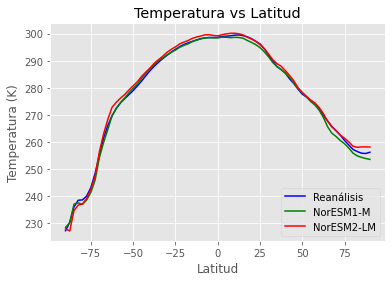

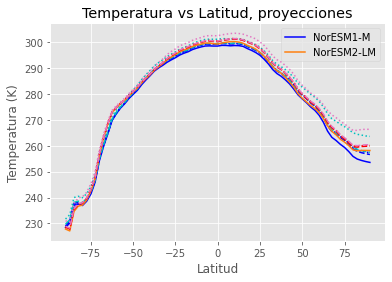

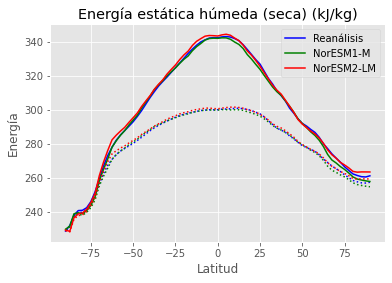

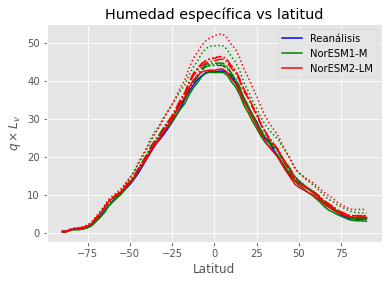

In [35]:
def moist_static_surf(tas, q):
    #return (1005 * tas * units['m**2/s**2'] + mpconsts.Lv * q) / 1000
    """Calcular la energía estática húmeda en superficie (z=0),
    Lv = 2501000 kJ/kg, Cp_d = 1005 kJ kg-1 K-1"""
    
    return (1005 * tas + 2501000 * q) / 1000


tmp_r.air.metpy.convert_units('kelvin')
with plt.style.context('ggplot'):
    tmp_r.air.mean(dim=('lon', 'time')).plot(color='b', label='Reanálisis')
    t_c5_hist['ds'].tas.mean(dim=('lon', 'time')).plot(color='g', label='NorESM1-M')
    t_c6_hist['ds'].tas.mean(dim=('lon', 'time')).plot(color='r', label='NorESM2-LM')
    plt.legend()
    plt.title('Temperatura vs Latitud')
    plt.xlabel('Latitud')
    plt.ylabel('Temperatura (K)')
plt.show()

with plt.style.context('ggplot'):
    t_c5_hist['ds'].tas.mean(dim=('lon', 'time')).plot(color='b', label='NorESM1-M')
    t_c5_26_close['ds'].tas.mean(dim=('lon', 'time')).plot(color='b', linestyle='--')
    t_c5_26_far['ds'].tas.mean(dim=('lon', 'time')).plot(color='b', linestyle=':')
    t_c5_85_close['ds'].tas.mean(dim=('lon', 'time')).plot(color='c', linestyle='--')
    t_c5_85_far['ds'].tas.mean(dim=('lon', 'time')).plot(color='c', linestyle=':')    
    t_c6_hist['ds'].tas.mean(dim=('lon', 'time')).plot(color='tab:orange', label='NorESM2-LM')
    t_c6_126_close['ds'].tas.mean(dim=('lon', 'time')).plot(color='r', linestyle='--')
    t_c6_126_far['ds'].tas.mean(dim=('lon', 'time')).plot(color='r', linestyle=':')
    t_c6_585_close['ds'].tas.mean(dim=('lon', 'time')).plot(color='tab:pink', linestyle='--')
    t_c6_585_far['ds'].tas.mean(dim=('lon', 'time')).plot(color='tab:pink', linestyle=':') 
    plt.legend()
    plt.title('Temperatura vs Latitud, proyecciones')
    plt.xlabel('Latitud')
    plt.ylabel('Temperatura (K)')
plt.show()


enthalpy_r = moist_static_surf(tmp_r.air, q_r)
ent_c5_hist = moist_static_surf(t_c5_hist['ds'].tas, h_c5_hist['ds'].huss)
ent_c5_26_close = moist_static_surf(t_c5_26_close['ds'].tas, h_c5_26_close['ds'].huss)
ent_c5_26_far = moist_static_surf(t_c5_26_far['ds'].tas, h_c5_26_far['ds'].huss)
ent_c5_85_close = moist_static_surf(t_c5_85_close['ds'].tas, h_c5_85_close['ds'].huss)
ent_c5_85_far = moist_static_surf(t_c5_85_far['ds'].tas, h_c5_85_far['ds'].huss)


ent_c6_hist = moist_static_surf(t_c6_hist['ds'].tas, h_c6_hist['ds'].huss)
ent_c6_126_close = moist_static_surf(t_c6_126_close['ds'].tas, h_c6_126_close['ds'].huss)
ent_c6_126_far = moist_static_surf(t_c6_126_far['ds'].tas, h_c6_126_far['ds'].huss)
ent_c6_585_close = moist_static_surf(t_c6_585_close['ds'].tas, h_c6_585_close['ds'].huss)
ent_c6_585_far = moist_static_surf(t_c6_585_far['ds'].tas, h_c6_585_far['ds'].huss)

with plt.style.context('ggplot'):
    enthalpy_r.mean(dim=('lon', 'time')).plot(color='b', label='Reanálisis')

    (tmp_r.air * 1.005).mean(dim=('lon', 'time')).plot(color='b', linestyle=':')
    ent_c5_hist.mean(dim=('lon', 'time')).plot(color='g', label='NorESM1-M')
    (t_c5_hist['ds'].tas * 1.005).mean(dim=('lon', 'time')).plot(color='g', linestyle=':')
#(h_c5_hist['ds'].huss * 2501).mean(dim=('lon', 'time')).plot(color='g', linestyle=':')
    ent_c6_hist.mean(dim=('lon', 'time')).plot(color='r', label='NorESM2-LM')
    (t_c6_hist['ds'].tas * 1.005).mean(dim=('lon', 'time')).plot(color='r', linestyle=':')
    plt.xlabel('Latitud')
    plt.ylabel('Energía')
    plt.legend()
    plt.title('Energía estática húmeda (kJ/kg)')
plt.show()

with plt.style.context('ggplot'):
    enthalpy_r.mean(dim=('lon', 'time')).plot(color='b', label='Reanálisis')

    (tmp_r.air * 1.005).mean(dim=('lon', 'time')).plot(color='b', linestyle=':')
    ent_c5_hist.mean(dim=('lon', 'time')).plot(color='g', label='NorESM1-M')
    (t_c5_hist['ds'].tas * 1.005).mean(dim=('lon', 'time')).plot(color='g', linestyle=':')
#(h_c5_hist['ds'].huss * 2501).mean(dim=('lon', 'time')).plot(color='g', linestyle=':')
    ent_c6_hist.mean(dim=('lon', 'time')).plot(color='r', label='NorESM2-LM')
    (t_c6_hist['ds'].tas * 1.005).mean(dim=('lon', 'time')).plot(color='r', linestyle=':')
    plt.xlabel('Latitud')
    plt.ylabel('Energía')
    plt.legend()
    plt.title('Energía estática húmeda (kJ/kg)')
plt.show()

with plt.style.context('ggplot'):
    (2501 * q_r.mean(dim=('lon','time'))).plot(color='b', label='Reanálisis')
    (2501 * h_c5_hist['ds'].huss.mean(dim=('lon', 'time'))).plot(color='g', label='NorESM1-M')
    (2501 * h_c5_26_close['ds'].huss.mean(dim=('lon', 'time'))).plot(color='g', linestyle='dashdot')
    (2501 * h_c5_26_far['ds'].huss.mean(dim=('lon', 'time'))).plot(color='g', linestyle=':')
    (2501 * h_c5_85_close['ds'].huss.mean(dim=('lon', 'time'))).plot(color='g', linestyle='dashdot')
    (2501 * h_c5_85_far['ds'].huss.mean(dim=('lon', 'time'))).plot(color='g', linestyle=':')
    (2501 * h_c6_hist['ds'].huss.mean(dim=('lon', 'time'))).plot(color='r', label='NorESM2-LM')
    (2501 * h_c6_126_close['ds'].huss.mean(dim=('lon', 'time'))).plot(color='r', linestyle='dashdot')
    (2501 * h_c6_126_far['ds'].huss.mean(dim=('lon', 'time'))).plot(color='r', linestyle=':')
    (2501 * h_c6_585_close['ds'].huss.mean(dim=('lon', 'time'))).plot(color='r', linestyle='dashdot')
    (2501 * h_c6_585_far['ds'].huss.mean(dim=('lon', 'time'))).plot(color='r', linestyle=':')    
    plt.legend()
    plt.xlabel('Latitud')
    plt.ylabel(r'$q \times L_v$')
    plt.title('Humedad específica vs latitud')
plt.show()

#print(type(enthalpy_c5_hist.time))


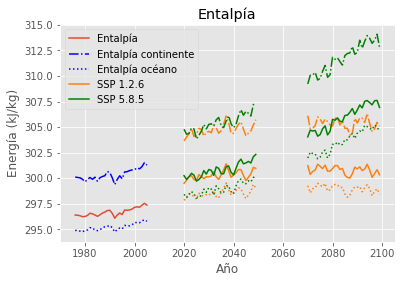

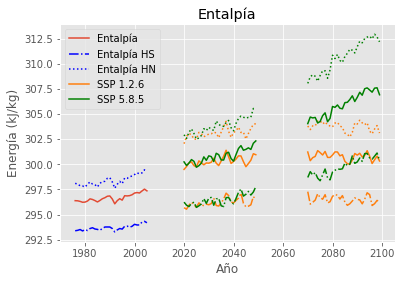

In [10]:
yearly_enthalpy = ent_c5_hist.groupby('time.year').mean('time')
y_ent_126_close = ent_c6_126_close.groupby('time.year').mean('time')
y_ent_126_far = ent_c6_126_far.groupby('time.year').mean('time')
y_ent_585_close = ent_c6_585_close.groupby('time.year').mean('time')
y_ent_585_far = ent_c6_585_far.groupby('time.year').mean('time')
yearly_tas = t_c6_hist['ds'].tas.groupby('time.year').mean('time')
yearly_q = h_c6_hist['ds'].huss.groupby('time.year').mean('time')
#plt.figure(figsize=(10,10))
with plt.style.context('ggplot'):
    plt.ylabel('Energía (kJ/kg)')
    plt.xlabel('Año')
    
    plt.plot(yearly_enthalpy.year.values, yearly_enthalpy.mean(dim=('lat', 'lon')), label='Entalpía')
    plt.plot(yearly_enthalpy.year.values, yearly_enthalpy.where(mask_land == 1).mean(dim=('lat', 'lon')),
             label='Entalpía continente', linestyle='dashdot', color='b')
    plt.plot(yearly_enthalpy.year.values, yearly_enthalpy.where(mask_ocean == 1).mean(dim=('lat', 'lon')),
             label='Entalpía océano', linestyle=':', color='b')
    
    plt.plot(y_ent_126_close.year.values, y_ent_126_close.mean(dim=('lat', 'lon')),
             color='tab:orange', label='SSP 1.2.6')
    plt.plot(y_ent_126_close.year.values, y_ent_126_close.where(mask_land == 1).mean(dim=('lat', 'lon')),
             color='tab:orange', linestyle='dashdot')
    plt.plot(y_ent_126_close.year.values, y_ent_126_close.where(mask_ocean == 1).mean(dim=('lat', 'lon')),
             color='tab:orange', linestyle=':')
    plt.plot(y_ent_126_far.year.values, y_ent_126_far.mean(dim=('lat', 'lon')), color='tab:orange')
    plt.plot(y_ent_126_far.year.values, y_ent_126_far.where(mask_land == 1).mean(dim=('lat', 'lon')),
             color='tab:orange', linestyle='dashdot')
    plt.plot(y_ent_126_far.year.values, y_ent_126_far.where(mask_ocean == 1).mean(dim=('lat', 'lon')),
             color='tab:orange', linestyle=':')
    
    
    
    plt.plot(y_ent_585_close.year.values, y_ent_585_close.mean(dim=('lat', 'lon')),
             color='g', label='SSP 5.8.5')
    plt.plot(y_ent_585_close.year.values, y_ent_585_close.where(mask_land == 1).mean(dim=('lat', 'lon')),
             color='g', linestyle='dashdot')
    plt.plot(y_ent_585_close.year.values, y_ent_585_close.where(mask_ocean == 1).mean(dim=('lat', 'lon')),
             color='g', linestyle=':')
    
    plt.plot(y_ent_585_far.year.values, y_ent_585_far.mean(dim=('lat', 'lon')), color='g')
    plt.plot(y_ent_585_far.year.values, y_ent_585_far.where(mask_land == 1).mean(dim=('lat', 'lon')),
             color='g', linestyle='dashdot')
    plt.plot(y_ent_585_far.year.values, y_ent_585_far.where(mask_ocean == 1).mean(dim=('lat', 'lon')),
             color='g', linestyle=':')
    #plt.plot(yearly_tas.year.values, yearly_tas.mean(dim=('lat', 'lon')) * 1.005, label='Aporte T')
    #plt.plot(yearly_q.year.values, yearly_q.mean(dim=('lat', 'lon')) * 2501, label='Aporte q')
    plt.legend()
    plt.title('Entalpía')
plt.show()

#plt.figure(figsize=(10,10))
with plt.style.context('ggplot'):
    plt.ylabel('Energía (kJ/kg)')
    plt.xlabel('Año')
    
    plt.plot(yearly_enthalpy.year.values, yearly_enthalpy.mean(dim=('lat', 'lon')), label='Entalpía')
    plt.plot(yearly_enthalpy.year.values, yearly_enthalpy.where(
             yearly_enthalpy.lat < 0).mean(dim=('lat', 'lon')),
             label='Entalpía HS', linestyle='dashdot', color='b')
    plt.plot(yearly_enthalpy.year.values, yearly_enthalpy.where(
             yearly_enthalpy.lat > 0).mean(dim=('lat', 'lon')),
             label='Entalpía HN', linestyle=':', color='b')
    
    plt.plot(y_ent_126_close.year.values, y_ent_126_close.mean(dim=('lat', 'lon')),
             color='tab:orange', label='SSP 1.2.6')
    plt.plot(y_ent_126_close.year.values, y_ent_126_close.where(yearly_enthalpy.lat < 0).mean(dim=('lat', 'lon')),
             color='tab:orange', linestyle='dashdot')
    plt.plot(y_ent_126_close.year.values, y_ent_126_close.where(yearly_enthalpy.lat > 0).mean(dim=('lat', 'lon')),
             color='tab:orange', linestyle=':')
    plt.plot(y_ent_126_far.year.values, y_ent_126_far.mean(dim=('lat', 'lon')), color='tab:orange')
    plt.plot(y_ent_126_far.year.values, y_ent_126_far.where(yearly_enthalpy.lat < 0).mean(dim=('lat', 'lon')),
             color='tab:orange', linestyle='dashdot')
    plt.plot(y_ent_126_far.year.values, y_ent_126_far.where(yearly_enthalpy.lat > 0).mean(dim=('lat', 'lon')),
             color='tab:orange', linestyle=':')
    
    
    
    plt.plot(y_ent_585_close.year.values, y_ent_585_close.mean(dim=('lat', 'lon')),
             color='g', label='SSP 5.8.5')
    plt.plot(y_ent_585_close.year.values, y_ent_585_close.where(yearly_enthalpy.lat < 0).mean(dim=('lat', 'lon')),
             color='g', linestyle='dashdot')
    plt.plot(y_ent_585_close.year.values, y_ent_585_close.where(yearly_enthalpy.lat > 0).mean(dim=('lat', 'lon')),
             color='g', linestyle=':')
    
    plt.plot(y_ent_585_far.year.values, y_ent_585_far.mean(dim=('lat', 'lon')), color='g')
    plt.plot(y_ent_585_far.year.values, y_ent_585_far.where(yearly_enthalpy.lat < 0).mean(dim=('lat', 'lon')),
             color='g', linestyle='dashdot')
    plt.plot(y_ent_585_far.year.values, y_ent_585_far.where(yearly_enthalpy.lat > 0).mean(dim=('lat', 'lon')),
             color='g', linestyle=':')
    #plt.plot(yearly_tas.year.values, yearly_tas.mean(dim=('lat', 'lon')) * 1.005, label='Aporte T')
    #plt.plot(yearly_q.year.values, yearly_q.mean(dim=('lat', 'lon')) * 2501, label='Aporte q')
    plt.legend()
    plt.title('Entalpía')
plt.show()

##########################################################################################################


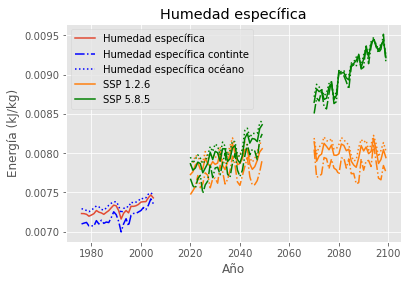

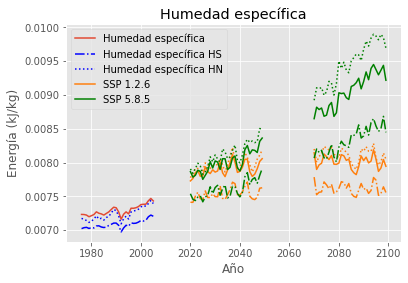

In [11]:
yearly_h = h_c5_hist['ds'].huss.groupby('time.year').mean('time')
y_h_126_close = h_c6_126_close['ds'].huss.groupby('time.year').mean('time')
y_h_126_far = h_c6_126_far['ds'].huss.groupby('time.year').mean('time')
y_h_585_close = h_c6_585_close['ds'].huss.groupby('time.year').mean('time')
y_h_585_far = h_c6_585_far['ds'].huss.groupby('time.year').mean('time')
yearly_huss = h_c6_hist['ds'].huss.groupby('time.year').mean('time')
yearly_q = h_c6_hist['ds'].huss.groupby('time.year').mean('time')
#plt.figure(figsize=(10,10))
with plt.style.context('ggplot'):
    plt.ylabel('Energía (kJ/kg)')
    plt.xlabel('Año')
    
    plt.plot(yearly_h.year.values, yearly_h.mean(dim=('lat', 'lon')), label='Humedad específica')
    plt.plot(yearly_h.year.values, yearly_h.where(mask_land == 1).mean(dim=('lat', 'lon')),
             label='Humedad específica continte', linestyle='dashdot', color='b')
    plt.plot(yearly_h.year.values, yearly_h.where(mask_ocean == 1).mean(dim=('lat', 'lon')),
             label='Humedad específica océano', linestyle=':', color='b')
    
    plt.plot(y_h_126_close.year.values, y_h_126_close.mean(dim=('lat', 'lon')),
             color='tab:orange', label='SSP 1.2.6')
    plt.plot(y_h_126_close.year.values, y_h_126_close.where(mask_land == 1).mean(dim=('lat', 'lon')),
             color='tab:orange', linestyle='dashdot')
    plt.plot(y_h_126_close.year.values, y_h_126_close.where(mask_ocean == 1).mean(dim=('lat', 'lon')),
             color='tab:orange', linestyle=':')
    plt.plot(y_h_126_far.year.values, y_h_126_far.mean(dim=('lat', 'lon')), color='tab:orange')
    plt.plot(y_h_126_far.year.values, y_h_126_far.where(mask_land == 1).mean(dim=('lat', 'lon')),
             color='tab:orange', linestyle='dashdot')
    plt.plot(y_h_126_far.year.values, y_h_126_far.where(mask_ocean == 1).mean(dim=('lat', 'lon')),
             color='tab:orange', linestyle=':')
    
    
    
    plt.plot(y_h_585_close.year.values, y_h_585_close.mean(dim=('lat', 'lon')),
             color='g', label='SSP 5.8.5')
    plt.plot(y_h_585_close.year.values, y_h_585_close.where(mask_land == 1).mean(dim=('lat', 'lon')),
             color='g', linestyle='dashdot')
    plt.plot(y_h_585_close.year.values, y_h_585_close.where(mask_ocean == 1).mean(dim=('lat', 'lon')),
             color='g', linestyle=':')
    
    plt.plot(y_h_585_far.year.values, y_h_585_far.mean(dim=('lat', 'lon')), color='g')
    plt.plot(y_h_585_far.year.values, y_h_585_far.where(mask_land == 1).mean(dim=('lat', 'lon')),
             color='g', linestyle='dashdot')
    plt.plot(y_h_585_far.year.values, y_h_585_far.where(mask_ocean == 1).mean(dim=('lat', 'lon')),
             color='g', linestyle=':')
    #plt.plot(yearly_has.year.values, yearly_has.mean(dim=('lat', 'lon')) * 1.005, label='Aporte T')
    #plt.plot(yearly_q.year.values, yearly_q.mean(dim=('lat', 'lon')) * 2501, label='Aporte q')
    plt.legend()
    plt.title('Humedad específica')
plt.show()

#plt.figure(figsize=(10,10))
with plt.style.context('ggplot'):
    plt.ylabel('Energía (kJ/kg)')
    plt.xlabel('Año')
    
    plt.plot(yearly_h.year.values, yearly_h.mean(dim=('lat', 'lon')), label='Humedad específica')
    plt.plot(yearly_h.year.values, yearly_h.where(
             yearly_h.lat < 0).mean(dim=('lat', 'lon')),
             label='Humedad específica HS', linestyle='dashdot', color='b')
    plt.plot(yearly_h.year.values, yearly_h.where(
             yearly_h.lat > 0).mean(dim=('lat', 'lon')),
             label='Humedad específica HN', linestyle=':', color='b')
    
    plt.plot(y_h_126_close.year.values, y_h_126_close.mean(dim=('lat', 'lon')),
             color='tab:orange', label='SSP 1.2.6')
    plt.plot(y_h_126_close.year.values, y_h_126_close.where(yearly_h.lat < 0).mean(dim=('lat', 'lon')),
             color='tab:orange', linestyle='dashdot')
    plt.plot(y_h_126_close.year.values, y_h_126_close.where(yearly_h.lat > 0).mean(dim=('lat', 'lon')),
             color='tab:orange', linestyle=':')
    plt.plot(y_h_126_far.year.values, y_h_126_far.mean(dim=('lat', 'lon')), color='tab:orange')
    plt.plot(y_h_126_far.year.values, y_h_126_far.where(yearly_h.lat < 0).mean(dim=('lat', 'lon')),
             color='tab:orange', linestyle='dashdot')
    plt.plot(y_h_126_far.year.values, y_h_126_far.where(yearly_h.lat > 0).mean(dim=('lat', 'lon')),
             color='tab:orange', linestyle=':')
    
    
    
    plt.plot(y_h_585_close.year.values, y_h_585_close.mean(dim=('lat', 'lon')),
             color='g', label='SSP 5.8.5')
    plt.plot(y_h_585_close.year.values, y_h_585_close.where(yearly_h.lat < 0).mean(dim=('lat', 'lon')),
             color='g', linestyle='dashdot')
    plt.plot(y_h_585_close.year.values, y_h_585_close.where(yearly_h.lat > 0).mean(dim=('lat', 'lon')),
             color='g', linestyle=':')
    
    plt.plot(y_h_585_far.year.values, y_h_585_far.mean(dim=('lat', 'lon')), color='g')
    plt.plot(y_h_585_far.year.values, y_h_585_far.where(yearly_h.lat < 0).mean(dim=('lat', 'lon')),
             color='g', linestyle='dashdot')
    plt.plot(y_h_585_far.year.values, y_h_585_far.where(yearly_h.lat > 0).mean(dim=('lat', 'lon')),
             color='g', linestyle=':')
    #plt.plot(yearly_has.year.values, yearly_has.mean(dim=('lat', 'lon')) * 1.005, label='Aporte T')
    #plt.plot(yearly_q.year.values, yearly_q.mean(dim=('lat', 'lon')) * 2501, label='Aporte q')
    plt.legend()
    plt.title('Humedad específica')
plt.show()

##########################################################################################################


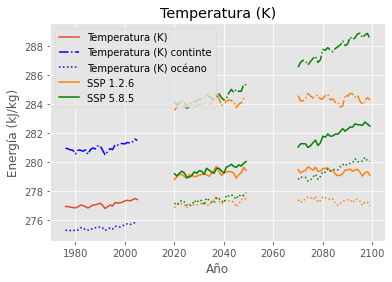

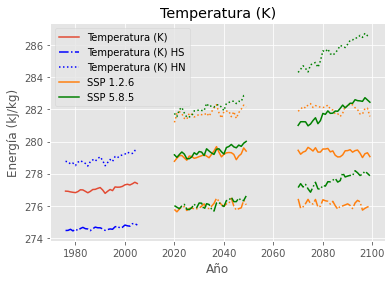

In [12]:
yearly_t = t_c5_hist['ds'].tas.groupby('time.year').mean('time')
y_t_126_close = t_c6_126_close['ds'].tas.groupby('time.year').mean('time')
y_t_126_far = t_c6_126_far['ds'].tas.groupby('time.year').mean('time')
y_t_585_close = t_c6_585_close['ds'].tas.groupby('time.year').mean('time')
y_t_585_far = t_c6_585_far['ds'].tas.groupby('time.year').mean('time')
yearly_tas = t_c6_hist['ds'].tas.groupby('time.year').mean('time')
yearly_q = h_c6_hist['ds'].huss.groupby('time.year').mean('time')
#plt.figure(figsize=(10,10))
with plt.style.context('ggplot'):
    plt.ylabel('Energía (kJ/kg)')
    plt.xlabel('Año')
    
    plt.plot(yearly_t.year.values, yearly_t.mean(dim=('lat', 'lon')), label='Temperatura (K)')
    plt.plot(yearly_t.year.values, yearly_t.where(mask_land == 1).mean(dim=('lat', 'lon')),
             label='Temperatura (K) continte', linestyle='dashdot', color='b')
    plt.plot(yearly_t.year.values, yearly_t.where(mask_ocean == 1).mean(dim=('lat', 'lon')),
             label='Temperatura (K) océano', linestyle=':', color='b')
    
    plt.plot(y_t_126_close.year.values, y_t_126_close.mean(dim=('lat', 'lon')),
             color='tab:orange', label='SSP 1.2.6')
    plt.plot(y_t_126_close.year.values, y_t_126_close.where(mask_land == 1).mean(dim=('lat', 'lon')),
             color='tab:orange', linestyle='dashdot')
    plt.plot(y_t_126_close.year.values, y_t_126_close.where(mask_ocean == 1).mean(dim=('lat', 'lon')),
             color='tab:orange', linestyle=':')
    plt.plot(y_t_126_far.year.values, y_t_126_far.mean(dim=('lat', 'lon')), color='tab:orange')
    plt.plot(y_t_126_far.year.values, y_t_126_far.where(mask_land == 1).mean(dim=('lat', 'lon')),
             color='tab:orange', linestyle='dashdot')
    plt.plot(y_t_126_far.year.values, y_t_126_far.where(mask_ocean == 1).mean(dim=('lat', 'lon')),
             color='tab:orange', linestyle=':')
    
    
    
    plt.plot(y_t_585_close.year.values, y_t_585_close.mean(dim=('lat', 'lon')),
             color='g', label='SSP 5.8.5')
    plt.plot(y_t_585_close.year.values, y_t_585_close.where(mask_land == 1).mean(dim=('lat', 'lon')),
             color='g', linestyle='dashdot')
    plt.plot(y_t_585_close.year.values, y_t_585_close.where(mask_ocean == 1).mean(dim=('lat', 'lon')),
             color='g', linestyle=':')
    
    plt.plot(y_t_585_far.year.values, y_t_585_far.mean(dim=('lat', 'lon')), color='g')
    plt.plot(y_t_585_far.year.values, y_t_585_far.where(mask_land == 1).mean(dim=('lat', 'lon')),
             color='g', linestyle='dashdot')
    plt.plot(y_t_585_far.year.values, y_t_585_far.where(mask_ocean == 1).mean(dim=('lat', 'lon')),
             color='g', linestyle=':')
    #plt.plot(yearly_tas.year.values, yearly_tas.mean(dim=('lat', 'lon')) * 1.005, label='Aporte T')
    #plt.plot(yearly_q.year.values, yearly_q.mean(dim=('lat', 'lon')) * 2501, label='Aporte q')
    plt.legend()
    plt.title('Temperatura (K)')
plt.show()

#plt.figure(figsize=(10,10))
with plt.style.context('ggplot'):
    plt.ylabel('Energía (kJ/kg)')
    plt.xlabel('Año')
    
    plt.plot(yearly_t.year.values, yearly_t.mean(dim=('lat', 'lon')), label='Temperatura (K)')
    plt.plot(yearly_t.year.values, yearly_t.where(
             yearly_t.lat < 0).mean(dim=('lat', 'lon')),
             label='Temperatura (K) HS', linestyle='dashdot', color='b')
    plt.plot(yearly_t.year.values, yearly_t.where(
             yearly_t.lat > 0).mean(dim=('lat', 'lon')),
             label='Temperatura (K) HN', linestyle=':', color='b')
    
    plt.plot(y_t_126_close.year.values, y_t_126_close.mean(dim=('lat', 'lon')),
             color='tab:orange', label='SSP 1.2.6')
    plt.plot(y_t_126_close.year.values, y_t_126_close.where(yearly_t.lat < 0).mean(dim=('lat', 'lon')),
             color='tab:orange', linestyle='dashdot')
    plt.plot(y_t_126_close.year.values, y_t_126_close.where(yearly_t.lat > 0).mean(dim=('lat', 'lon')),
             color='tab:orange', linestyle=':')
    plt.plot(y_t_126_far.year.values, y_t_126_far.mean(dim=('lat', 'lon')), color='tab:orange')
    plt.plot(y_t_126_far.year.values, y_t_126_far.where(yearly_t.lat < 0).mean(dim=('lat', 'lon')),
             color='tab:orange', linestyle='dashdot')
    plt.plot(y_t_126_far.year.values, y_t_126_far.where(yearly_t.lat > 0).mean(dim=('lat', 'lon')),
             color='tab:orange', linestyle=':')
    
    
    
    plt.plot(y_t_585_close.year.values, y_t_585_close.mean(dim=('lat', 'lon')),
             color='g', label='SSP 5.8.5')
    plt.plot(y_t_585_close.year.values, y_t_585_close.where(yearly_t.lat < 0).mean(dim=('lat', 'lon')),
             color='g', linestyle='dashdot')
    plt.plot(y_t_585_close.year.values, y_t_585_close.where(yearly_t.lat > 0).mean(dim=('lat', 'lon')),
             color='g', linestyle=':')
    
    plt.plot(y_t_585_far.year.values, y_t_585_far.mean(dim=('lat', 'lon')), color='g')
    plt.plot(y_t_585_far.year.values, y_t_585_far.where(yearly_t.lat < 0).mean(dim=('lat', 'lon')),
             color='g', linestyle='dashdot')
    plt.plot(y_t_585_far.year.values, y_t_585_far.where(yearly_t.lat > 0).mean(dim=('lat', 'lon')),
             color='g', linestyle=':')
    #plt.plot(yearly_tas.year.values, yearly_tas.mean(dim=('lat', 'lon')) * 1.005, label='Aporte T')
    #plt.plot(yearly_q.year.values, yearly_q.mean(dim=('lat', 'lon')) * 2501, label='Aporte q')
    plt.legend()
    plt.title('Temperatura (K)')
plt.show()

##########################################################################################################


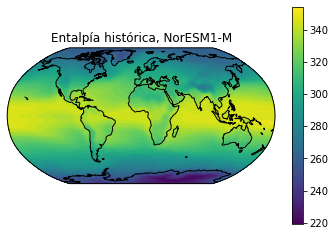

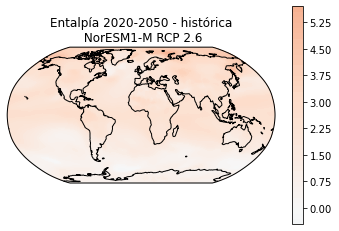

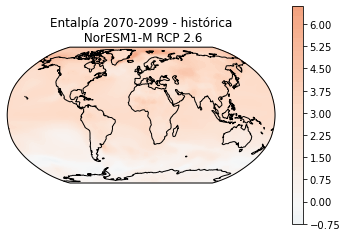

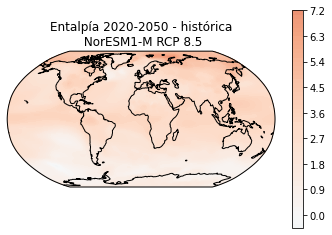

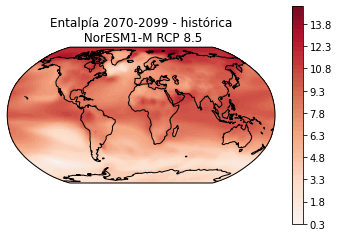

In [13]:
#ploteo = fm.ploteo_general(enthalpy_r.mean(dim='time'), projection=ccrs.Mollweide())
#plt.show()
#plt.figure(figsize=(20,10))
ax = plt.axes(projection=ccrs.Robinson())
#cyclic_enthalpy, cyclic_lon = add_cyclic_point(ent_c5_hist.mean(dim='time'), enthalpy_r.lon)
plt.contourf(ent_c5_hist.lon, ent_c5_hist.lat, ent_c5_hist.mean(dim='time'), transform=ccrs.PlateCarree(),
             cmap='viridis', vmax=354,
             levels=50)
cmap = plt.get_cmap()
norm = mpl.colors.Normalize(vmin=219, vmax=354)
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap))
ax.coastlines()
plt.title('Entalpía histórica, NorESM1-M')
plt.show()

ax = plt.axes(projection=ccrs.Robinson())
#cyclic_enthalpy, cyclic_lon = add_cyclic_point(ent_c5_hist.mean(dim='time'), enthalpy_r.lon)
plt.contourf(ent_c5_hist.lon, ent_c5_hist.lat, 
             ent_c5_26_close.mean(dim='time') - ent_c5_hist.mean(dim='time'),
             transform=ccrs.PlateCarree(), cmap='RdBu_r',
             norm=MidpointNormalize(midpoint=0, vmin=-16, vmax=16),
             levels=50)
plt.colorbar()
ax.coastlines()
plt.title('Entalpía 2020-2050 - histórica\n NorESM1-M RCP 2.6')
plt.show()


ax = plt.axes(projection=ccrs.Robinson())
#cyclic_enthalpy, cyclic_lon = add_cyclic_point(ent_c5_hist.mean(dim='time'), enthalpy_r.lon)
plt.contourf(ent_c5_hist.lon, ent_c5_hist.lat, 
             ent_c5_26_far.mean(dim='time') - ent_c5_hist.mean(dim='time'),
             transform=ccrs.PlateCarree(), cmap='RdBu_r', 
             norm=MidpointNormalize(midpoint=0, vmin=-16, vmax=16),
             levels=50)
plt.colorbar()
ax.coastlines()
plt.title('Entalpía 2070-2099 - histórica\n NorESM1-M RCP 2.6')
plt.show()

ax = plt.axes(projection=ccrs.Robinson())
#cyclic_enthalpy, cyclic_lon = add_cyclic_point(ent_c5_hist.mean(dim='time'), enthalpy_r.lon)
plt.contourf(ent_c5_hist.lon, ent_c5_hist.lat, 
             ent_c5_85_close.mean(dim='time') - ent_c5_hist.mean(dim='time'),
             transform=ccrs.PlateCarree(), cmap='RdBu_r', 
             norm=MidpointNormalize(midpoint=0, vmin=-16, vmax=16),
             levels=50)
plt.colorbar()
ax.coastlines()
plt.title('Entalpía 2020-2050 - histórica\n NorESM1-M RCP 8.5')
plt.show()


ax = plt.axes(projection=ccrs.Robinson())
#cyclic_enthalpy, cyclic_lon = add_cyclic_point(ent_c5_hist.mean(dim='time'), enthalpy_r.lon)
plt.contourf(ent_c5_hist.lon, ent_c5_hist.lat, 
             ent_c5_85_far.mean(dim='time') - ent_c5_hist.mean(dim='time'),
             transform=ccrs.PlateCarree(), cmap='RdBu_r',
             norm=MidpointNormalize(midpoint=0, vmin=-16, vmax=16),
             levels=50)
plt.colorbar()
ax.coastlines()
plt.title('Entalpía 2070-2099 - histórica\n NorESM1-M RCP 8.5')
plt.show()



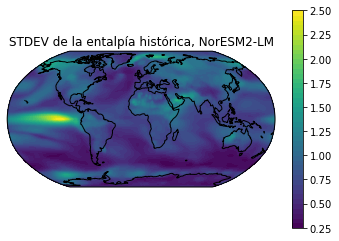

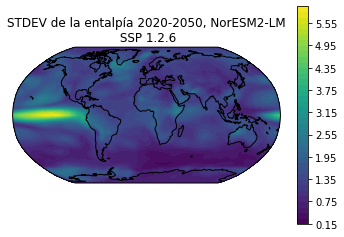

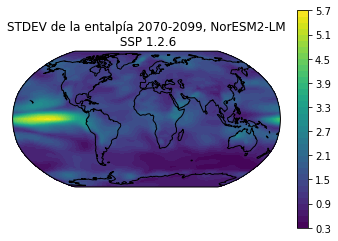

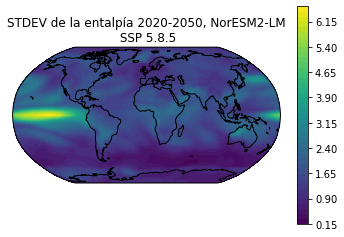

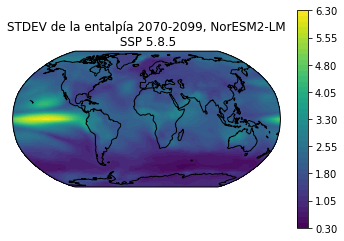

In [14]:
#ploteo = fm.ploteo_general(enthalpy_r.mean(dim='time'), projection=ccrs.Mollweide())
#plt.show()
#plt.figure(figsize=(20,10))
ax = plt.axes(projection=ccrs.Robinson())
#cyclic_enthalpy, cyclic_lon = add_cyclic_point(ent_c6_hist.mean(dim='time'), enthalpy_r.lon)
plt.contourf(ent_c6_hist.lon, ent_c6_hist.lat, yearly_enthalpy.std(dim='year'), transform=ccrs.PlateCarree(),
             cmap='viridis',
             levels=50)
cmap = plt.get_cmap()
#norm = mpl.colors.Normalize(vmin=None, vmax=None)
plt.colorbar()

ax.coastlines()
plt.title('STDEV de la entalpía histórica, NorESM2-LM')
plt.show()

ax = plt.axes(projection=ccrs.Robinson())
#cyclic_enthalpy, cyclic_lon = add_cyclic_point(ent_c6_hist.mean(dim='time'), enthalpy_r.lon)
plt.contourf(ent_c6_hist.lon, ent_c6_hist.lat, 
             y_ent_126_close.std(dim='year'),
             transform=ccrs.PlateCarree(), cmap='viridis',
             #norm=MidpointNormalize(vmin=None, vmax=None),
             levels=50)
plt.colorbar()
ax.coastlines()
plt.title('STDEV de la entalpía 2020-2050, NorESM2-LM\n SSP 1.2.6')
plt.show()


ax = plt.axes(projection=ccrs.Robinson())
#cyclic_enthalpy, cyclic_lon = add_cyclic_point(ent_c6_hist.mean(dim='time'), enthalpy_r.lon)
plt.contourf(ent_c6_hist.lon, ent_c6_hist.lat, 
             y_ent_126_far.std(dim='year'),
             transform=ccrs.PlateCarree(), cmap='viridis', 
             levels=50)
plt.colorbar()
ax.coastlines()
plt.title('STDEV de la entalpía 2070-2099, NorESM2-LM\n SSP 1.2.6')
plt.show()

ax = plt.axes(projection=ccrs.Robinson())
#cyclic_enthalpy, cyclic_lon = add_cyclic_point(ent_c6_hist.mean(dim='time'), enthalpy_r.lon)
plt.contourf(ent_c6_hist.lon, ent_c6_hist.lat, 
             y_ent_585_close.std(dim='year'),
             transform=ccrs.PlateCarree(), cmap='viridis', 
             levels=50)
plt.colorbar()
ax.coastlines()
plt.title('STDEV de la entalpía 2020-2050, NorESM2-LM\n SSP 5.8.5')
plt.show()


ax = plt.axes(projection=ccrs.Robinson())
#cyclic_enthalpy, cyclic_lon = add_cyclic_point(ent_c6_hist.mean(dim='time'), enthalpy_r.lon)
plt.contourf(ent_c6_hist.lon, ent_c6_hist.lat, 
             y_ent_585_far.std(dim='year'),
             transform=ccrs.PlateCarree(), cmap='viridis',
             levels=50)
plt.colorbar()
ax.coastlines()
plt.title('STDEV de la entalpía 2070-2099, NorESM2-LM\n SSP 5.8.5')
plt.show()


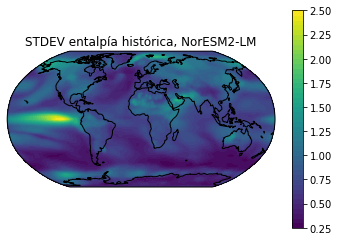

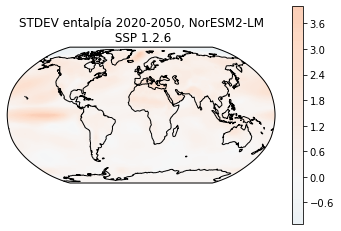

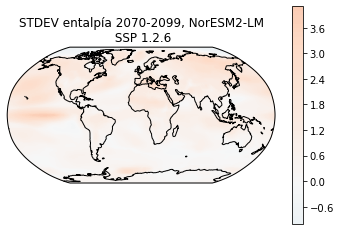

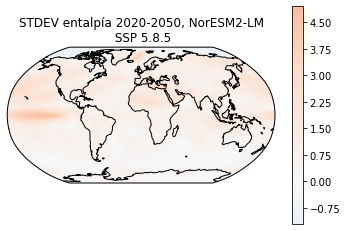

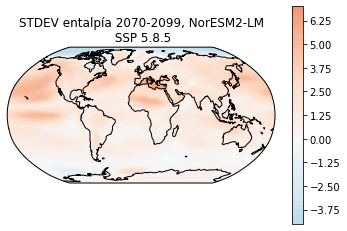

In [15]:
# Variabilidad de la entalpía
#ploteo = fm.ploteo_general(enthalpy_r.std(dim='time'), projection=ccrs.Mollweide())
#plt.show()
#plt.figure(figsize=(20,10))
ax = plt.axes(projection=ccrs.Robinson())
#cyclic_enthalpy, cyclic_lon = add_cyclic_point(ent_c6_hist.std(dim='time'), enthalpy_r.lon)
plt.contourf(yearly_enthalpy.lon, yearly_enthalpy.lat, yearly_enthalpy.std(dim='year'), transform=ccrs.PlateCarree(),
             cmap='viridis',
             levels=50)
#cmap = plt.get_cmap()
#norm = mpl.colors.Normalize(vmin=219, vmax=354)
plt.colorbar()

ax.coastlines()
plt.title('STDEV entalpía histórica, NorESM2-LM')
plt.show()

ax = plt.axes(projection=ccrs.Robinson())
#cyclic_enthalpy, cyclic_lon = add_cyclic_point(ent_c6_hist.std(dim='time'), enthalpy_r.lon)
plt.contourf(ent_c6_hist.lon, ent_c6_hist.lat, 
             ent_c6_126_close.std(dim='time') - ent_c6_hist.std(dim='time'),
             transform=ccrs.PlateCarree(), cmap='RdBu_r',
             norm=MidpointNormalize(midpoint=0, vmin=-16, vmax=16),
             levels=50)
plt.colorbar()
ax.coastlines()
plt.title('STDEV entalpía 2020-2050, NorESM2-LM\n SSP 1.2.6')
plt.show()


ax = plt.axes(projection=ccrs.Robinson())
#cyclic_enthalpy, cyclic_lon = add_cyclic_point(ent_c6_hist.std(dim='time'), enthalpy_r.lon)
plt.contourf(ent_c6_hist.lon, ent_c6_hist.lat, 
             ent_c6_126_far.std(dim='time') - ent_c6_hist.std(dim='time'),
             transform=ccrs.PlateCarree(), cmap='RdBu_r', 
             norm=MidpointNormalize(midpoint=0, vmin=-16, vmax=16),
             levels=50)
plt.colorbar()
ax.coastlines()
plt.title('STDEV entalpía 2070-2099, NorESM2-LM\n SSP 1.2.6')
plt.show()

ax = plt.axes(projection=ccrs.Robinson())
#cyclic_enthalpy, cyclic_lon = add_cyclic_point(ent_c6_hist.std(dim='time'), enthalpy_r.lon)
plt.contourf(ent_c6_hist.lon, ent_c6_hist.lat, 
             ent_c6_585_close.std(dim='time') - ent_c6_hist.std(dim='time'),
             transform=ccrs.PlateCarree(), cmap='RdBu_r', 
             norm=MidpointNormalize(midpoint=0, vmin=-16, vmax=16),
             levels=50)
plt.colorbar()
ax.coastlines()
plt.title('STDEV entalpía 2020-2050, NorESM2-LM\n SSP 5.8.5')
plt.show()


ax = plt.axes(projection=ccrs.Robinson())
#cyclic_enthalpy, cyclic_lon = add_cyclic_point(ent_c6_hist.std(dim='time'), enthalpy_r.lon)
plt.contourf(ent_c6_hist.lon, ent_c6_hist.lat, 
             ent_c6_585_far.std(dim='time') - ent_c6_hist.std(dim='time'),
             transform=ccrs.PlateCarree(), cmap='RdBu_r',
             norm=MidpointNormalize(midpoint=0, vmin=-16, vmax=16),
             levels=50)
plt.colorbar()
ax.coastlines()
plt.title('STDEV entalpía 2070-2099, NorESM2-LM\n SSP 5.8.5')
plt.show()


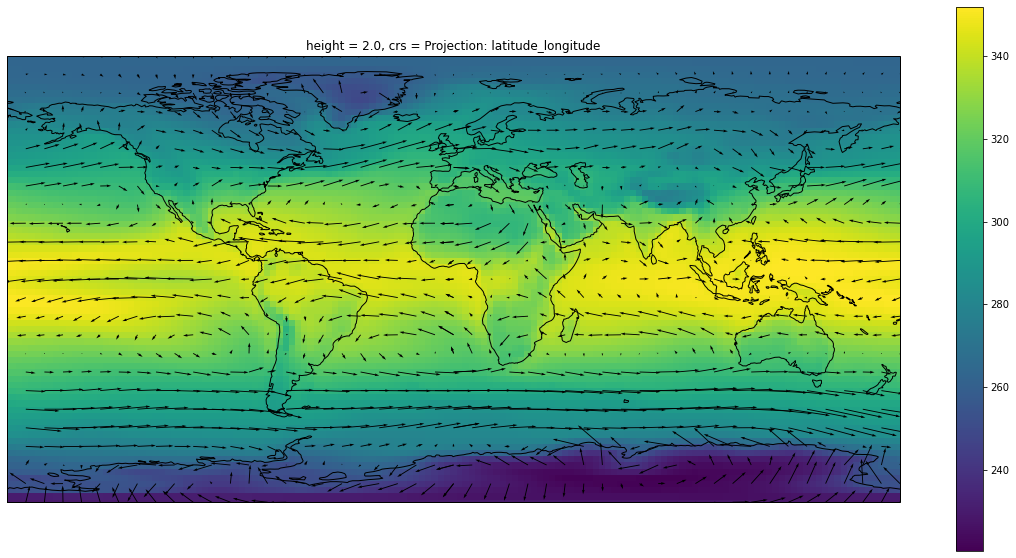

In [16]:
#Divergencia de FS

#FS
def calc_FA(h, u, v):
    g = 9.80665
    FA_x = 1/g * h * u
    FA_y = 1/g * h * v
    return FA_x, FA_y

FA_hist = calc_FA(ent_c6_hist, u_c6_hist['ds'].ua.isel(plev=0), v_c6_hist['ds'].va.isel(plev=0))

lon = t_c6_hist['ds'].lon.values * units.degrees
lat = t_c6_hist['ds'].lat.values * units.degrees


plt.figure(figsize=(20,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ent_c6_hist.mean('time').plot(transform=ccrs.PlateCarree())
ax.quiver(FA_hist[0].lon.values[0::3],
          FA_hist[0].lat.values[0::3], FA_hist[0].mean(dim=('time')).values[0::3,0::3],
          FA_hist[1].mean(dim=('time')).values[0::3,0::3], width=0.001, transform=ccrs.PlateCarree())
#          regrid_shape=20, width=0.001)
ax.coastlines()
plt.show()

In [17]:
print(mpconsts.Lv)
print(mpconsts.Cp_d)
print(mpconsts.g)

2501000.0 meter ** 2 / second ** 2
1005 meter ** 2 / kelvin / second ** 2
9.80665 meter / second ** 2
